# Using Recipe Ingredients to Categorize Cuisine

By Eka Renardi. October 7, 2015

## Introduction

This document outline my solution for solving this Kaggle Competition. Kaggle posed a challenge for predicting the category of cuisine based on its recipe ingredients. 

### Dataset

*Yummly* graciously provided the dataset for this challenge. The dataset consists of train and test set. The train set listed the cuisines, and ingredients for the cuisine.  The test set data listed just the ingredients. A sample train data set is as follows:

```
{
    "id": 25693,
    "cuisine": "southern_us",
    "ingredients": [
      "plain flour",
      "ground pepper",
      "salt",
      "tomatoes",
      "ground black pepper",
      "thyme",
      "eggs",
      "green tomatoes",
      "yellow corn meal",
      "milk",
      "vegetable oil"
    ]
}
```

Attributes:

- "id" - unique identifier
- "cuisine" - category of a cuisine
- "ingredients" - ingredients used to make the cuisine


## Exploratory Statistics

In my attempt to understand the data, several exploratory statistics are constructed. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt    
from collections import Counter, defaultdict
import seaborn as sns
from nltk.stem.porter import *

sns.set_style('whitegrid')

df = pd.read_json("../data/train.json")

#### How many unique cuisines are there, and what are they?

('shape:', (39774, 3))
('unique cuisine count:', 20)


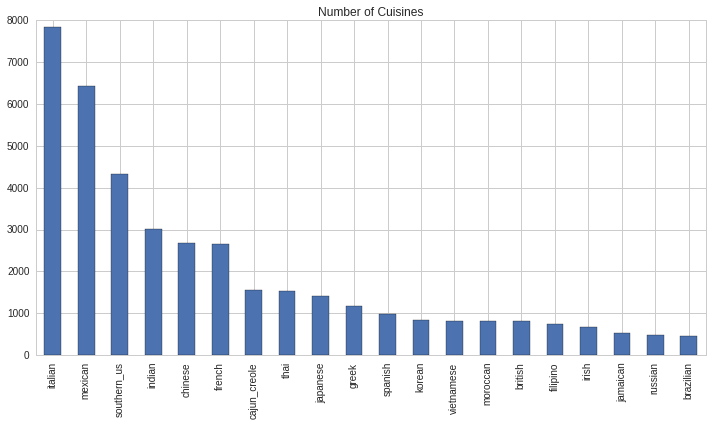

In [2]:
cuisines = df.cuisine.value_counts(sort=True)
cuisines.plot(kind="bar", figsize=(12,6), title="Number of Cuisines")
print("shape:", df.shape)
print("unique cuisine count:", len(df.cuisine.unique()))

#### What is the most often used ingredients by all cuisine? and what is the most often used ingredients for each cuisine?

In [3]:
# calculating the usage of each ingredient, and for each cuisine
cuisine_dict = defaultdict(Counter)
index_dict = defaultdict(Counter)
total_counter = Counter()
stemmer = PorterStemmer()
# iterate each row
for index, row in df.iterrows():
    # get the counters
    row_counter = index_dict[row.id] 
    local_counter = cuisine_dict[row.cuisine]
    # count the ingredients usage
    arr = row.ingredients
    for ingredient in row.ingredients:
        # stemm the ingredient string, e.g. 'eggs' is the same as 'egg'
        lemm_ingredient = ' '.join([stemmer.stem(word) for word in ingredient.split(' ')])
        # increment each word count
        total_counter[lemm_ingredient] += 1
        local_counter[lemm_ingredient] += 1
        row_counter[lemm_ingredient] += 1
    # update the counters
    cuisine_dict[row.cuisine] = local_counter
    index_dict[row.id] = row_counter
    

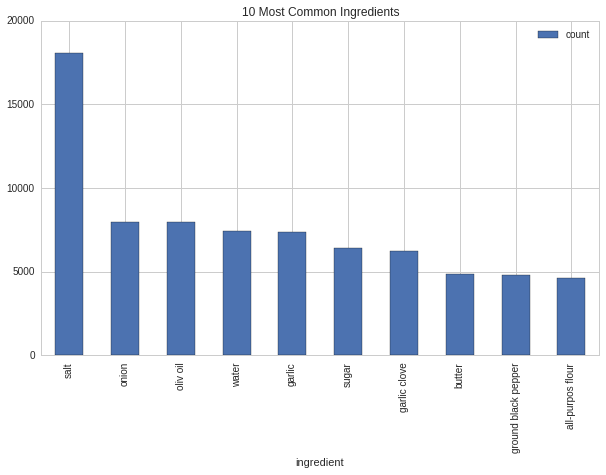

In [4]:
# plotting it
data1 = pd.DataFrame(total_counter.most_common(10), columns=["ingredient", "count"])
data1.plot(kind="bar", x="ingredient", figsize=(10,6), title="10 Most Common Ingredients")   

Let's draw a word cloud for top 100 ingredients.

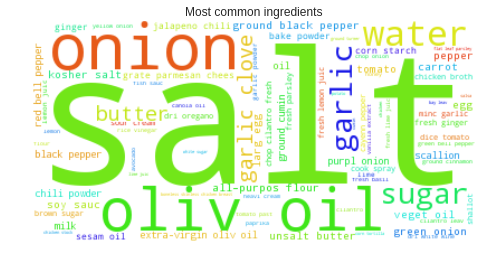

In [5]:
from wordcloud import WordCloud
wordcloudobj = WordCloud( background_color='white')
wordcloud = wordcloudobj.generate_from_frequencies(total_counter.most_common(100))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common ingredients")
plt.show()

Now let's look at the 100 most common ingredients used for each cuisine

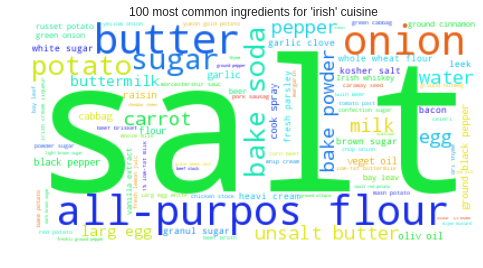

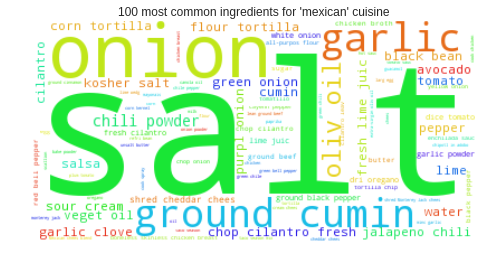

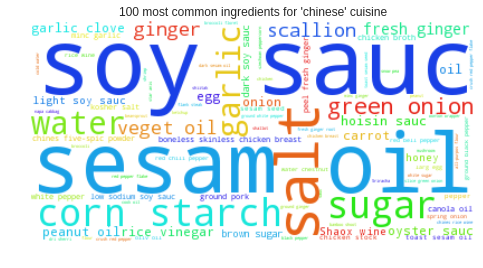

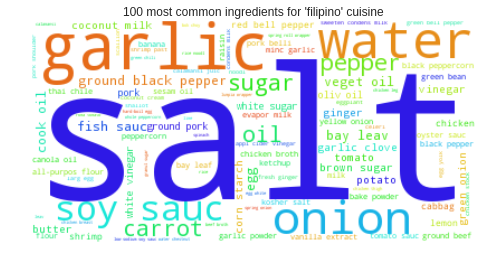

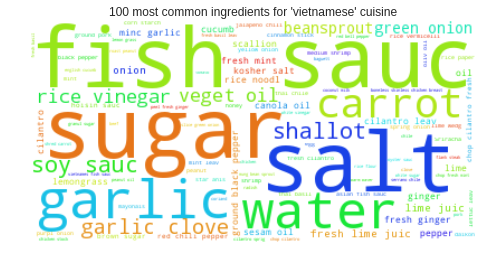

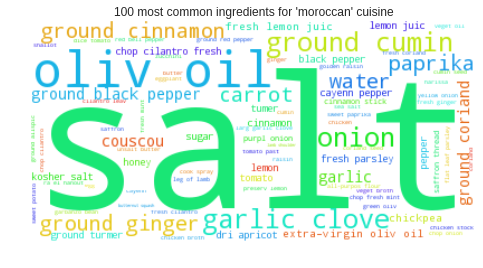

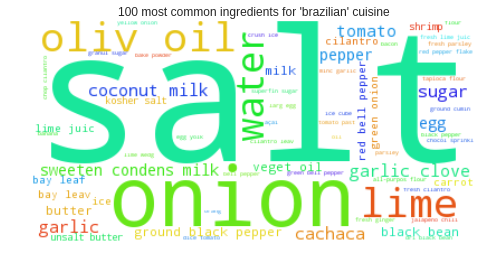

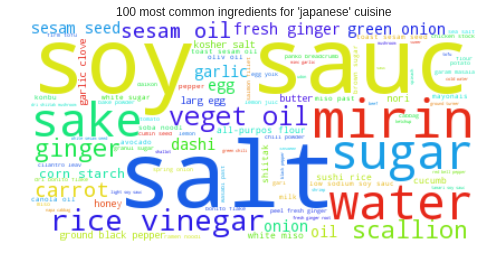

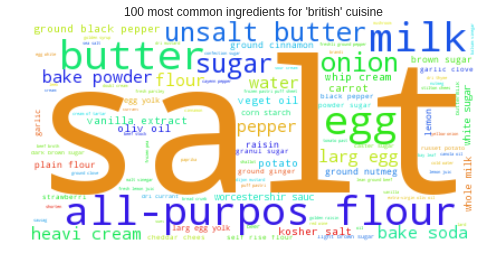

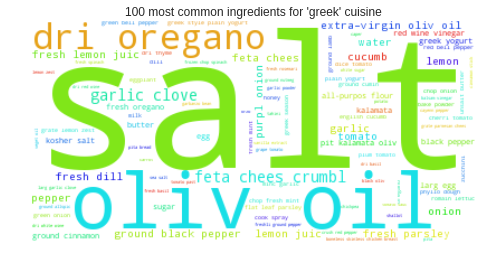

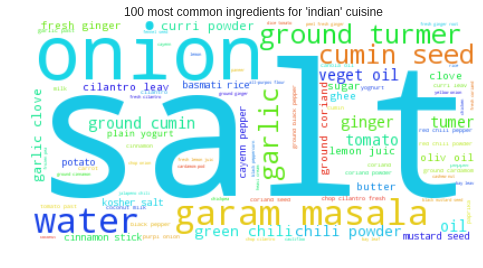

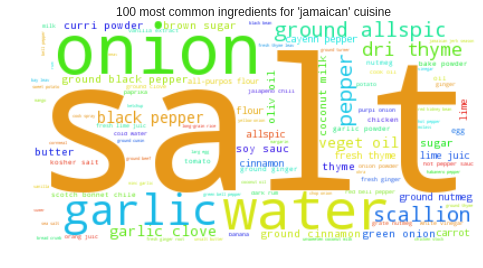

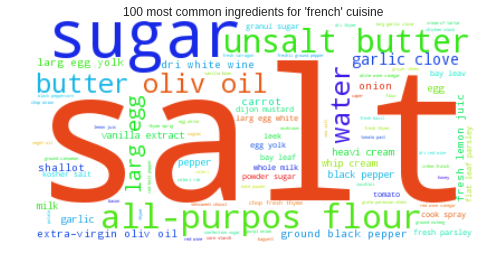

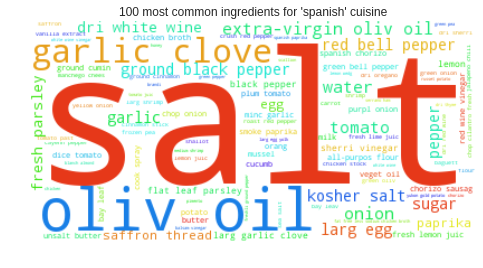

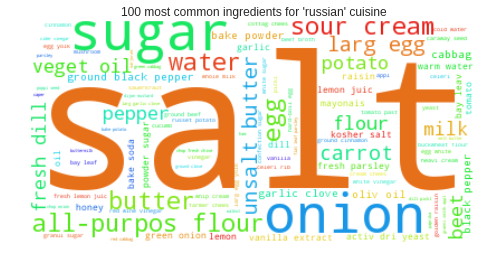

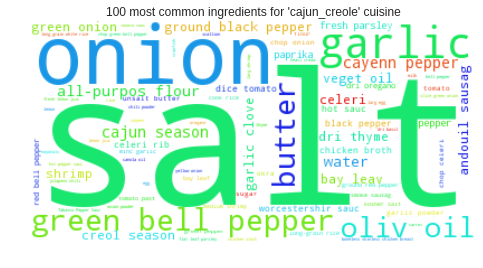

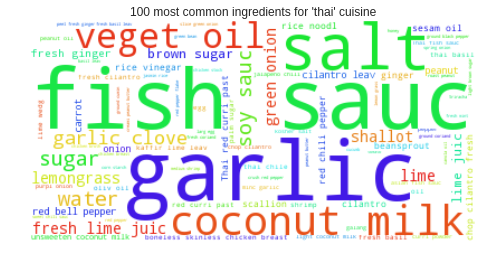

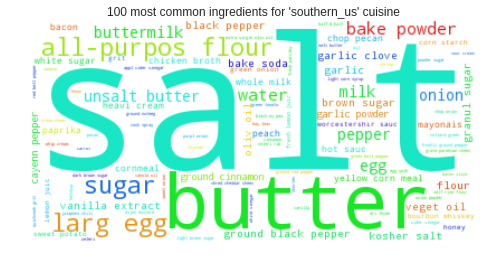

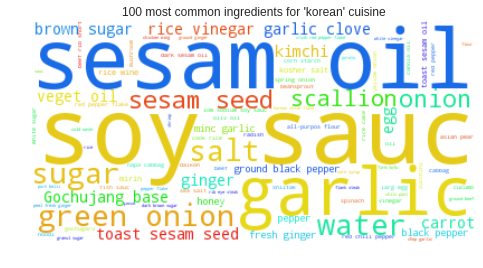

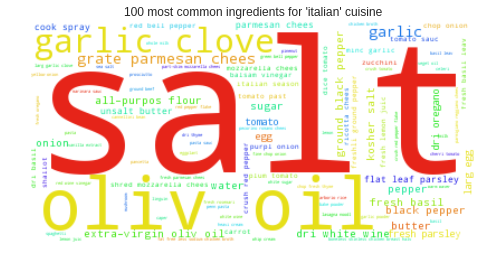

In [6]:
for key, value in cuisine_dict.iteritems():
    wc = wordcloudobj.generate_from_frequencies(value.most_common(100))
    plt.imshow(wc)
    plt.title("100 most common ingredients for '%s' cuisine" % key)
    plt.axis("off")
    plt.show()    

## Model Building

### 1. Multi-Dimensional Scaling

In this approach, the first step is the profile matrix for each cuisine and its ingredients.  

In [7]:
index1 = {}
for key, value in cuisine_dict.iteritems():
    index1[key] = dict(value)
df1 = pd.DataFrame.from_dict(index1, orient='index')
df1 = df1.fillna(0)
cuisine_labels = [key for key, value in df1.iterrows()]
ingredients_labels = list(df1.columns)

In [8]:
df1.shape

(20, 6708)

In [9]:
df1.head()

,lamb stew meat,dijon mustard,yellow corn meal,fresh chervil,salmon fillet,hot sauc,savoy cabbag,ground cardamom,extra sharp white cheddar chees,bread crumb,...,breadcrumb mix,reduc sodium chicken stock,"tortellini, cook and drain",granita,unsalt beef stock,chioggia,low-fat parmesan chees,refriger seamless crescent dough,gelato,bertolli organ tradit sauc
brazilian,0,3,2,0,4,11,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
british,0,18,2,0,3,3,4,1,2,15,...,0,0,0,0,0,0,0,0,0,0
cajun_creole,0,30,17,1,3,169,0,1,0,16,...,0,0,0,0,0,0,0,0,0,0
chinese,0,7,0,0,4,15,13,0,0,1,...,0,0,0,0,0,0,0,0,0,0
filipino,0,1,0,0,3,0,1,1,0,10,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# calculating the table of probabilities for the cuisines
inst_count=df1.sum(axis='columns')
df1_prob= df1.div(inst_count,axis='rows')
df1_prob

,lamb stew meat,dijon mustard,yellow corn meal,fresh chervil,salmon fillet,hot sauc,savoy cabbag,ground cardamom,extra sharp white cheddar chees,bread crumb,...,breadcrumb mix,reduc sodium chicken stock,"tortellini, cook and drain",granita,unsalt beef stock,chioggia,low-fat parmesan chees,refriger seamless crescent dough,gelato,bertolli organ tradit sauc
brazilian,0.000000,0.000675,0.000450,0.000000,0.000900,0.002474,0.000000,0.000000,0.000000,0.001574,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
british,0.000000,0.002306,0.000256,0.000000,0.000384,0.000384,0.000512,0.000128,0.000256,0.001922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cajun_creole,0.000000,0.001538,0.000872,0.000051,0.000154,0.008664,0.000000,0.000051,0.000000,0.000820,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chinese,0.000000,0.000219,0.000000,0.000000,0.000125,0.000468,0.000406,0.000000,0.000000,0.000031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
filipino,0.000000,0.000132,0.000000,0.000000,0.000397,0.000000,0.000132,0.000132,0.000000,0.001325,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
french,0.000038,0.006544,0.000231,0.000269,0.001001,0.000269,0.000269,0.000192,0.000038,0.000924,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
greek,0.000167,0.001337,0.000000,0.000000,0.000167,0.000334,0.000000,0.000084,0.000000,0.001337,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
indian,0.000105,0.000183,0.000052,0.000000,0.000472,0.000183,0.000000,0.004560,0.000000,0.000472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
irish,0.000967,0.001935,0.000645,0.000161,0.000322,0.000161,0.000645,0.000484,0.000161,0.000161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
italian,0.000026,0.001275,0.000824,0.000039,0.000142,0.000258,0.000129,0.000077,0.000000,0.001326,...,0.000013,0.000013,0.000026,0.000013,0.000013,0.000013,0.000013,0.000013,0.000052,0.000013


In [11]:
df1_prob.iloc[0].sum()

0.9999999999999816

In [12]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.datasets import make_classification
import matplotlib.pylab as pyl
pyl.rcParams['figure.figsize'] = (10.0, 8.0)

mds = MDS(n_components=2)

Drawing a profile map for the cuisines

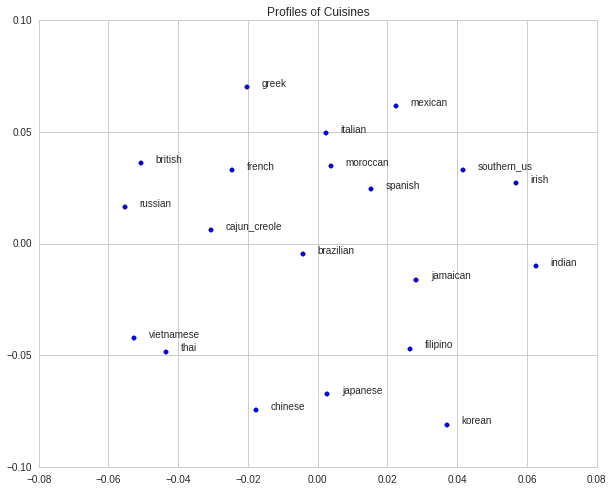

In [13]:
X=mds.fit_transform(df1_prob.astype(np.float64))

x1 = X[:,0]
y1 = X[:,1]

fig, ax = plt.subplots()
ax=plt.scatter(x1,y1)
plt.title('Profiles of Cuisines')
for i, name in enumerate(cuisine_labels):
    plt.annotate(name, (x1[i],y1[i]),xytext=(15,1),textcoords='offset points')
plt.show()

From this map, there are several groupings that I can draw.  The asian/southeast-asian cuisines (indian, vietnamese, thai, chinese, japanese, filipino, and korean), for the most part are on the lower half of the map.  The south-american cuisines (brazilian, jamaican, cajun_creole) are on the center of the map.  And the european cuisines are on the upper part of the map.

In [14]:
# calculating the table of probabilities for ingredients
df2=df1.T
df2.head()
sc_count=df2.sum(axis='columns')
df2_prob= df2.div(sc_count,axis='rows')
df2_prob

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
lamb stew meat,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.090909,0.181818,0.272727,0.090909,0.000000,0.000000,0.000000,0.045455,0.227273,0.045455,0.000000,0.000000,0.000000,0.000000
dijon mustard,0.005848,0.035088,0.058480,0.013645,0.001949,0.331384,0.031189,0.013645,0.023392,0.192982,0.011696,0.021442,0.005848,0.035088,0.005848,0.017544,0.165692,0.023392,0.003899,0.001949
yellow corn meal,0.005865,0.005865,0.049853,0.000000,0.000000,0.017595,0.000000,0.005865,0.011730,0.187683,0.002933,0.000000,0.000000,0.073314,0.000000,0.000000,0.633431,0.005865,0.000000,0.000000
fresh chervil,0.000000,0.000000,0.066667,0.000000,0.000000,0.466667,0.000000,0.000000,0.066667,0.200000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.133333,0.000000,0.000000,0.000000
salmon fillet,0.025157,0.018868,0.018868,0.025157,0.018868,0.163522,0.012579,0.113208,0.012579,0.069182,0.018868,0.301887,0.006289,0.018868,0.031447,0.050314,0.018868,0.006289,0.069182,0.000000
hot sauc,0.016320,0.004451,0.250742,0.022255,0.000000,0.010386,0.005935,0.010386,0.001484,0.029674,0.010386,0.011869,0.014837,0.267062,0.000000,0.004451,0.287834,0.017804,0.019288,0.014837
savoy cabbag,0.000000,0.072727,0.000000,0.236364,0.018182,0.127273,0.000000,0.000000,0.072727,0.181818,0.000000,0.109091,0.000000,0.036364,0.000000,0.090909,0.000000,0.036364,0.018182,0.000000
ground cardamom,0.000000,0.004219,0.004219,0.000000,0.004219,0.021097,0.004219,0.734177,0.012658,0.025316,0.008439,0.037975,0.000000,0.008439,0.084388,0.016878,0.025316,0.004219,0.004219,0.000000
extra sharp white cheddar chees,0.000000,0.200000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.100000,0.300000,0.000000,0.000000,0.000000
bread crumb,0.022876,0.049020,0.052288,0.003268,0.032680,0.078431,0.052288,0.058824,0.003268,0.336601,0.049020,0.006536,0.000000,0.039216,0.009804,0.016340,0.133987,0.039216,0.013072,0.003268


In [15]:
# validating calculation
print df2['brazilian'].sum(), df1.iloc[0].sum()
print df2.iloc[0].sum(), sc_count['lamb stew meat']

4446.0 4446.0
22.0 22.0


In [ ]:
pyl.rcParams['figure.figsize'] = (12.0, 24.0)
X2=mds.fit_transform(df2_prob.astype(np.float64))

x2 = X2[:,0]
y2 = X2[:,1]

fig, ax = plt.subplots()
ax=plt.scatter(x2,y2)
plt.title('Profiles of Ingredients')
for i, name in enumerate(ingredients_labels):
    plt.annotate(name, (x2[i],y2[i]),xytext=(15,1),textcoords='offset points')
plt.show()

Interpretation...


### 3. LDA Topic Modeling

### 4. Random Forest Classification

### 5. Multi-class Classification
One vs All


## Summary